# Setup

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import os

2023-11-16 05:53:25.436580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 05:53:25.563383: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 05:53:26.093007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-16 05:53:26.093071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
DIR_AMAZON = "office31/amazon"
DIR_DSLR = "office31/dslr"
DIR_WEBCAM = "office31/webcam"

In [3]:
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DIM = 3

EPOCHS = 100

# W_CATEGORICAL = 0.1
# W_ADVERSARIAL = 0
# W_DOMAIN      = 1

SOURCE = DIR_DSLR
TARGET = DIR_WEBCAM

latent_dim = 128

# Preparation Part

In [4]:
dataset_source = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 498 files belonging to 31 classes.
Using 399 files for training.


2023-11-16 05:53:26.921833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 05:53:27.518517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22822 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:37:00.0, compute capability: 7.5


In [5]:
dataset_source_val = tf.keras.utils.image_dataset_from_directory(
  SOURCE,                                                     # change DIR according to the dataset
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 498 files belonging to 31 classes.
Using 99 files for validation.


In [6]:
dataset_target = tf.keras.utils.image_dataset_from_directory(
  TARGET,                                                     # change DIR according to the dataset
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 795 files belonging to 31 classes.


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

dataset_source = dataset_source.map(lambda x, y: (normalization_layer(x), y))
dataset_source_val = dataset_source_val.map(lambda x, y: (normalization_layer(x), y))
dataset_target = dataset_target.map(lambda x, y: (normalization_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
dataset = tf.data.Dataset.zip((dataset_source, dataset_source_val, dataset_target))

In [9]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [10]:

@tf.function
def train_step(real_images, real_label, test_images, test_label, target_images, target_label):
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Decode them to fake images
    generated_images = generator(random_latent_vectors)
    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat(
        [tf.ones((BATCH_SIZE, 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(labels.shape)

    combined_domain = tf.concat([target_images, real_images], axis=0)

    # Assemble labels classifying target from source images
    labels_domain = tf.concat(
        [tf.ones((target_images.shape[0], 1)), tf.zeros((real_images.shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels_domain += 0.05 * tf.random.uniform(labels_domain.shape)



    # Train the discriminator
    with tf.GradientTape(persistent=True) as tape:
        features = feature_extractor(combined_images)
        predictions_disc = discriminator(features)
        # predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions_disc)

        features = feature_extractor(real_images)
        predictions_clas = categorical_classifier(features)
        # predictions = classifier(real_images)
        c_loss = loss_fn_cls(real_label, predictions_clas)

        features = feature_extractor(combined_domain)
        predictions_domain = domain_classifier(features)
        domain_loss = loss_fn(labels_domain, predictions_domain)
        domain_loss = -1 * domain_loss

        # fe_loss = total_loss(predictions_disc, labels, predictions_clas, real_label)
        fe_loss = W_ADVERSARIAL * d_loss + W_CATEGORICAL * c_loss + W_DOMAIN * domain_loss
        
        tf.print(d_loss, )

    grads_feature_extractor = tape.gradient(fe_loss, feature_extractor.trainable_weights)
    fe_optimizer.apply_gradients(zip(grads_feature_extractor, feature_extractor.trainable_weights))

    grads_discriminator = tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads_discriminator, discriminator.trainable_weights))

    grads_categorical = tape.gradient(c_loss, categorical_classifier.trainable_weights)
    c_optimizer.apply_gradients(zip(grads_categorical, categorical_classifier.trainable_weights))

    grads_domain = tape.gradient(domain_loss, domain_classifier.trainable_weights)
    domain_optimizer.apply_gradients(zip(grads_domain, domain_classifier.trainable_weights))



    #################################

    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(BATCH_SIZE, latent_dim))
    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((BATCH_SIZE, 1))

    # Train the generator (note that we should *not* update the weights
    # of the discriminator)!
    with tf.GradientTape() as tape:
        features = feature_extractor(generator(random_latent_vectors))
        predictions = discriminator(features)
        # predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))


    c_acc_t = train_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(real_images)), 1) , real_label)
    c_acc_v = val_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(test_images)), 1), test_label)
    c_acc_target = target_accuracy(tf.math.argmax(categorical_classifier(feature_extractor(target_images)), 1), target_label)

    return c_acc_target, c_acc_v, c_acc_t, domain_loss, c_loss, d_loss, g_loss, fe_loss

In [11]:
def plot_loss_values(gl_, al_, cl_, dl_, tl_):
  x = np.arange(len(gl_))

  plt.plot(x, gl_, label = "generative loss", linestyle="-.")
  plt.plot(x, al_, label = "adversarial loss", linestyle="-")
  plt.plot(x, cl_, label = "categorical loss", linestyle="--")
  plt.plot(x, dl_, label = "domain loss", linestyle=":")
  plt.plot(x, tl_, label = "total loss", linestyle=(0, (3, 1, 1, 1)))
  plt.legend()
  plt.show()

In [12]:
def plot_acc_values(acc_source_, acc_target_, acc_source_val_):
  x = np.arange(len(acc_source_))
  plt.plot(x, acc_source_, label = "source acc", linestyle="-")
  plt.plot(x, acc_target_, label = "target acc", linestyle=":")
  plt.plot(x, acc_source_val_, label = "val acc", linestyle="-.")
  plt.legend()
  plt.show()

# Training LOOP

In [13]:
# W_CATEGORICAL = 0.1
# W_ADVERSARIAL = 0
# W_DOMAIN      = 1

FinalResult = []

for W_CATEGORICAL in np.arange(0,1.1,.5):
    for W_ADVERSARIAL in np.arange(0,1.1,.5):
        for W_DOMAIN in np.arange(0,1.1,.5):
            
            tf.keras.backend.clear_session()
            
            feature_extractor = tf.keras.applications.InceptionV3(
                weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DIM),
                include_top=False)

            feature_extractor.trainable = False

            feature_extractor = keras.Sequential(
                [
                    feature_extractor,
                    layers.GlobalAveragePooling2D(),
                    layers.Flatten(),
                    layers.Dropout(0.5),
                    layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),

                ],
                name="feature_extractor",
            )

            for x, y in dataset_source.take(1):
              features = feature_extractor(x)

            categorical_classifier = keras.Sequential(
                [
                    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                    layers.Dropout(0.3),
                    layers.Dense(31, activation='softmax'),
                ],
                name="categorical_classifier",
            )
            cls = categorical_classifier(features)

            domain_classifier = keras.Sequential(
                [
                    layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                    layers.Dropout(0.3),
                    GradReverse(),
                    layers.Dense(1),
                ],
                name="domain_classifier",
            )
            feature_maps = domain_classifier(features)

            discriminator = keras.Sequential(
                [
                    # layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
                    # layers.Dropout(0.3),
                    layers.Dense(1),
                ],
                name="discriminator",
            )
            disc = discriminator(features)

            #RGB



            generator = keras.Sequential(
                [
                    keras.Input(shape=(latent_dim,)),
                    # We want to generate 128 coefficients to reshape into a 7x7x128 map
                    layers.Dense(8 * 8 * 128),
                    layers.LeakyReLU(alpha=0.2),
                    layers.Reshape((8, 8, 128)),
                    layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same"),
                    layers.LeakyReLU(alpha=0.2),
                    # layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                    # layers.LeakyReLU(alpha=0.2),
                    layers.Conv2D(3, (8, 8), padding="same", activation="sigmoid"),
                ],
                name="generator",
            )

            gen_data = generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))


            # Instantiate one optimizer for the discriminator and another for the generator.
            d_optimizer = keras.optimizers.Adam()
            g_optimizer = keras.optimizers.Adam()
            c_optimizer = keras.optimizers.Adam()
            fe_optimizer = keras.optimizers.Adam()
            domain_optimizer = keras.optimizers.Adam()

            # Instantiate a loss function.
            loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
            loss_fn_cls = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

            val_accuracy = tf.keras.metrics.Accuracy()
            train_accuracy = tf.keras.metrics.Accuracy()
            target_accuracy = tf.keras.metrics.Accuracy()


            ###################################################################

            gl_, al_, cl_, dl_, tl_, acc_source_, acc_target_, acc_source_val_ = [], [], [], [], [], [], [], []

            for epoch in range(EPOCHS):


                for step, ((real_images, real_label), (test_images, test_label), (target_images, target_label)) in enumerate(dataset):
                    # Train the discriminator & generator on one batch of real images.
                    acc_target, acc_source_val, acc_source, domain_loss, categorical_loss, adversarial_loss, generative_loss, fe_loss = train_step(real_images, real_label, test_images, test_label, target_images, target_label)

                    gl_ += [generative_loss]
                    al_ += [adversarial_loss]
                    cl_ += [categorical_loss]
                    dl_ += [domain_loss]
                    tl_ += [fe_loss]
                    acc_source_ += [acc_source]
                    acc_target_ += [acc_target]
                    acc_source_val_ +=[acc_source_val]

                    # Logging.
            #         if step % 50 == 0:
            #             # Print metrics
#                 clear_output(wait=True)
#                 print("Epoch: ", epoch)
#                 print("\ndomain loss at step %d: %.3f" % (step, domain_loss))
#                 print("discriminator loss at step %d: %.3f" % (step, adversarial_loss))
#                 print("adversarial loss at step %d: %.3f" % (step, generative_loss))
#                 print("categorical loss at step %d: %.3f" % (step, categorical_loss))
#                 print("\ncategorical train Accu at step %d: %.3f" % (step, acc_source))
#                 print("categorical val Accu at step %d: %.3f" % (step, acc_source_val))
#                 print("categorical target Accu at step %d: %.3f" % (step, acc_target))

#                 plot_loss_values(gl_, al_, cl_, dl_, tl_)
#                 plot_acc_values(acc_source_, acc_target_, acc_source_val_)
            tempResult = {'W_CATEGORICAL' : W_CATEGORICAL,
                          'W_ADVERSARIAL' : W_ADVERSARIAL,
                          'W_DOMAIN'      : W_DOMAIN,
                          'gl_':gl_, 
                          'al_':al_, 
                          'cl_':cl_, 
                          'dl_':dl_, 
                          'tl_':tl_, 
                          'acc_source_':acc_source_, 
                          'acc_target_':acc_target_, 
                          'acc_source_val_':acc_source_val_}
            FinalResult+=[tempResult]

            # save dictionary to person_data.pkl file
            print('W_CATEGORICAL: ', W_CATEGORICAL,
                  'W_ADVERSARIAL: ' , W_ADVERSARIAL,
                  'W_DOMAIN: ' , W_DOMAIN)
            

            
with open('result.pkl', 'wb') as fp:
    pickle.dump({'result':FinalResult}, fp)

2023-11-16 05:53:31.325087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-11-16 05:53:31.842739: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.0 W_DOMAIN:  0.0
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.0 W_DOMAIN:  0.5
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.0 W_DOMAIN:  1.0
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.5 W_DOMAIN:  0.0
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.5 W_DOMAIN:  0.5
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  0.5 W_DOMAIN:  1.0
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  1.0 W_DOMAIN:  0.0
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  1.0 W_DOMAIN:  0.5
W_CATEGORICAL:  0.0 W_ADVERSARIAL:  1.0 W_DOMAIN:  1.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.0 W_DOMAIN:  0.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.0 W_DOMAIN:  0.5
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.0 W_DOMAIN:  1.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.5 W_DOMAIN:  0.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.5 W_DOMAIN:  0.5
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  0.5 W_DOMAIN:  1.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  1.0 W_DOMAIN:  0.0
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  1.0 W_DOMAIN:  0.5
W_CATEGORICAL:  0.5 W_ADVERSARIAL:  1.0 W_DOMAIN:  1.0
W_CATEGORI

In [33]:
import pickle

# Read dictionary pkl file
with open('result.pkl', 'rb') as fp:
    person = pickle.load(fp)
    print('Person dictionary')
#     print(person)

Person dictionary


In [34]:
person['result'][0].keys()

dict_keys(['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN', 'gl_', 'al_', 'cl_', 'dl_', 'tl_', 'acc_source_', 'acc_target_', 'acc_source_val_'])

In [35]:
def plot_loss_values(gl_, al_, cl_, dl_, tl_):
  x = np.arange(len(gl_))

  plt.plot(x, gl_, label = "generative loss", linestyle="-.")
  plt.plot(x, al_, label = "adversarial loss", linestyle="-")
  plt.plot(x, cl_, label = "categorical loss", linestyle="--")
  plt.plot(x, dl_, label = "domain loss", linestyle=":")
  plt.plot(x, tl_, label = "total loss", linestyle=(0, (3, 1, 1, 1)))
  plt.legend()
  plt.show()




In [36]:
def plot_acc_values(acc_source_, acc_target_, acc_source_val_):
  x = np.arange(len(acc_source_))
  plt.plot(x, acc_source_, label = "source acc", linestyle="-")
  plt.plot(x, acc_target_, label = "target acc", linestyle=":")
  plt.plot(x, acc_source_val_, label = "val acc", linestyle="-.")
  plt.legend()
  plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.0


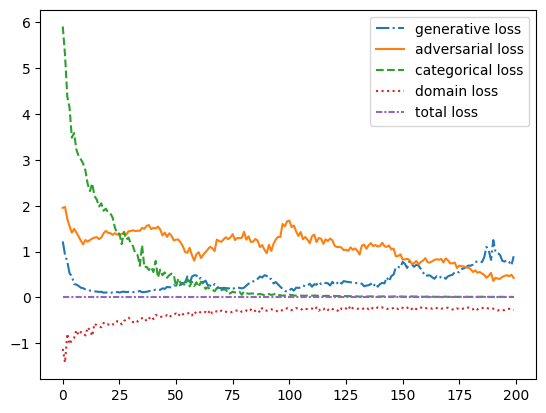

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.1


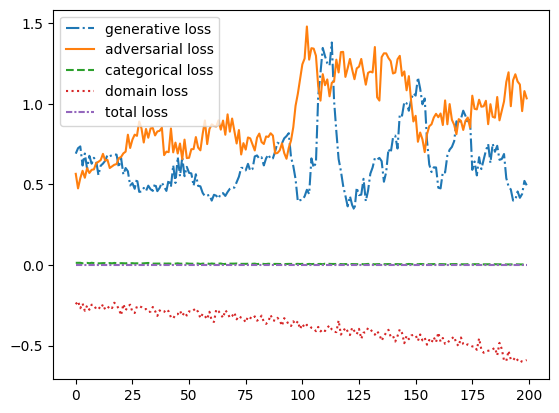

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.2


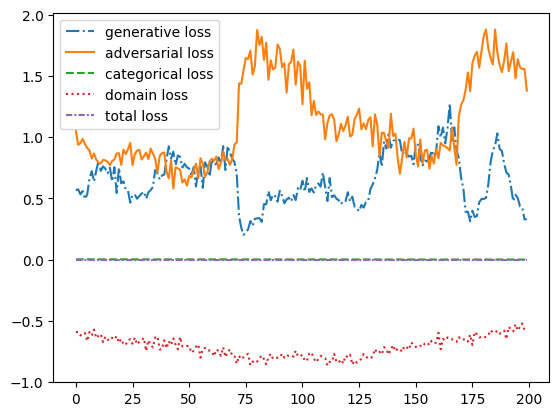

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.30000000000000004


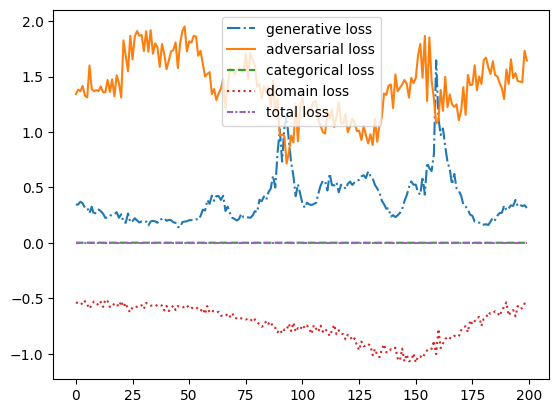

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.4


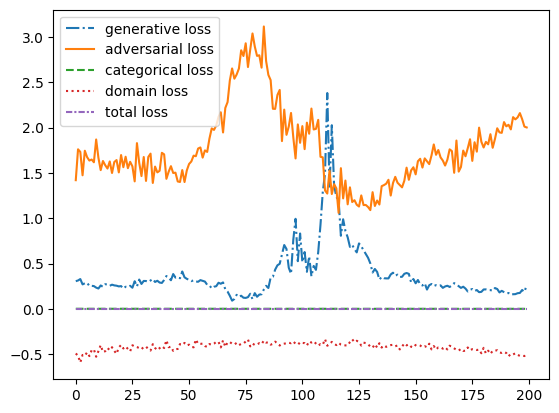

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.5


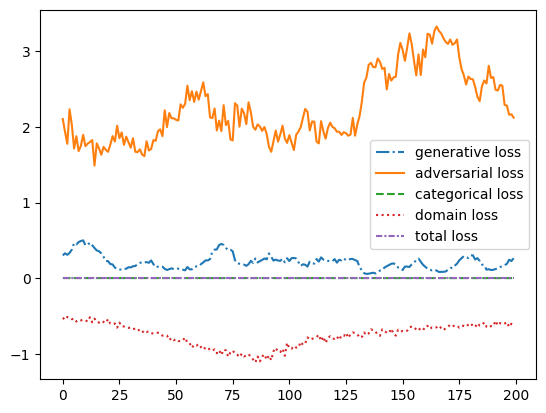

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.6000000000000001


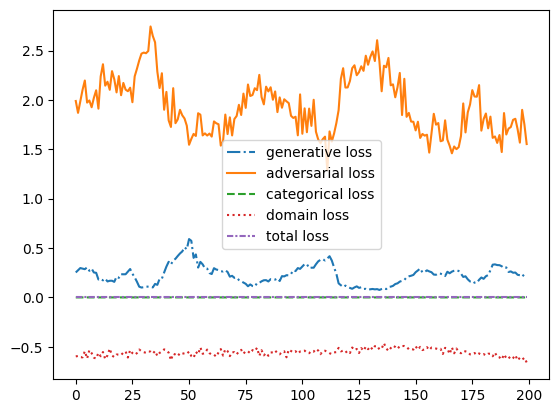

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.7000000000000001


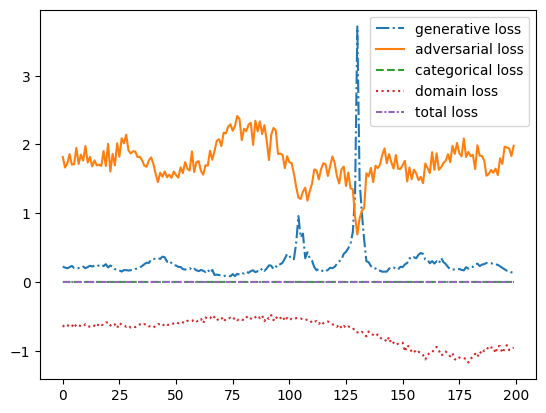

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.8


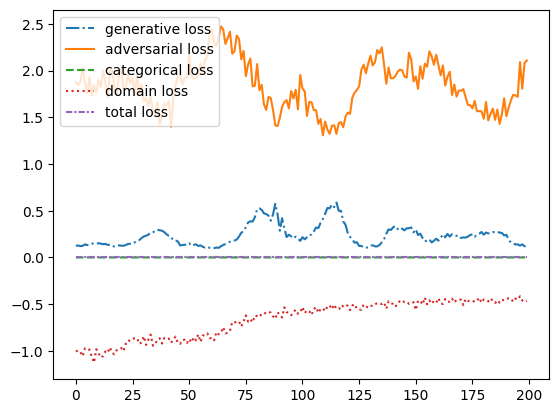

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.0
W_DOMAIN:  0.9


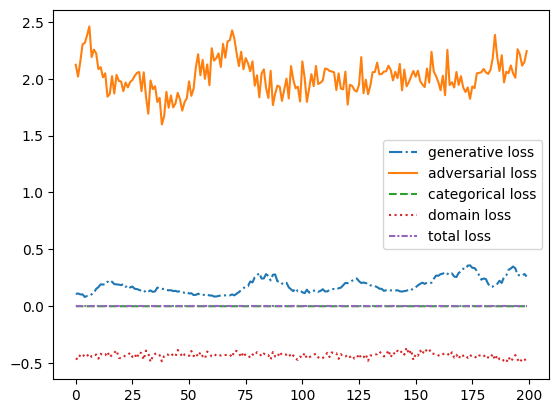

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.0


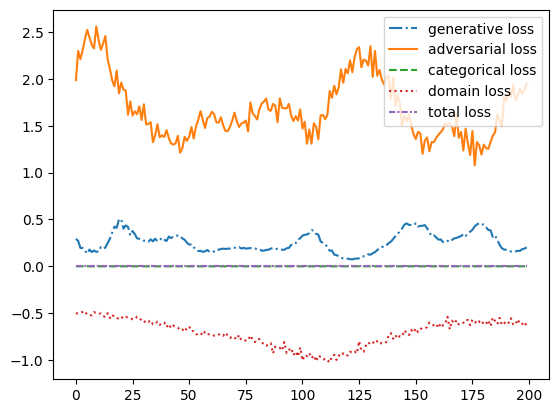

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.1


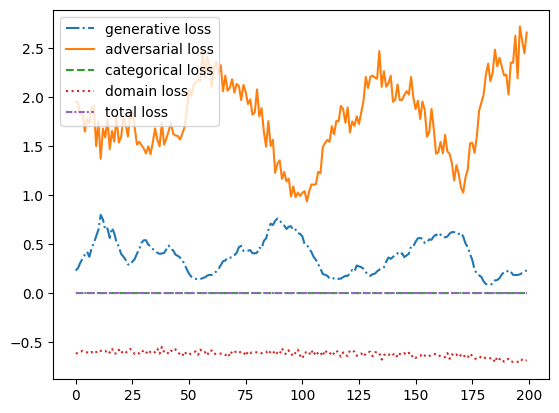

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.2


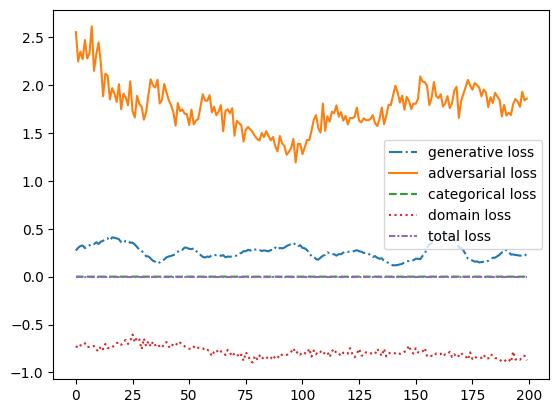

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.30000000000000004


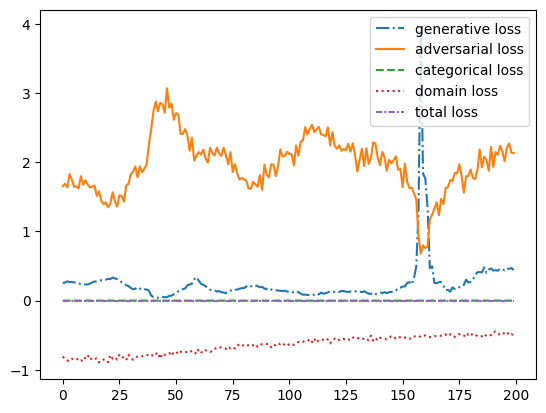

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.4


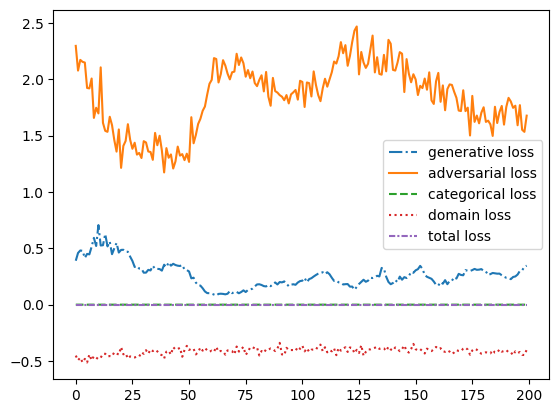

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.5


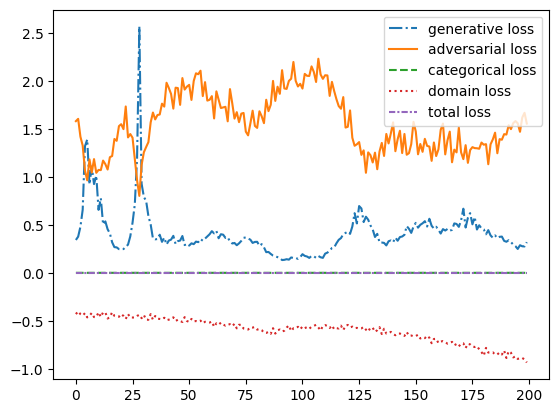

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.6000000000000001


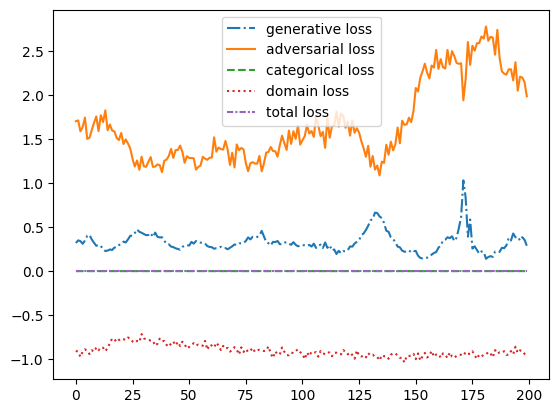

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.7000000000000001


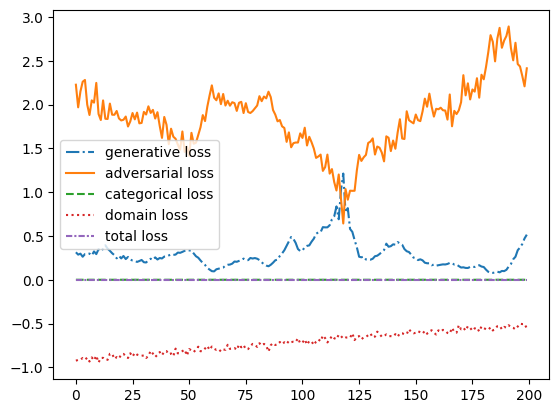

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.8


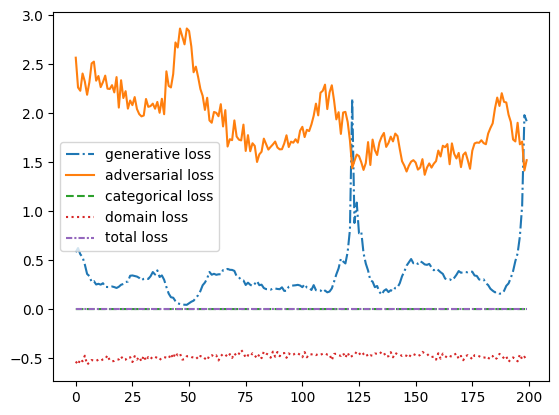

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.1
W_DOMAIN:  0.9


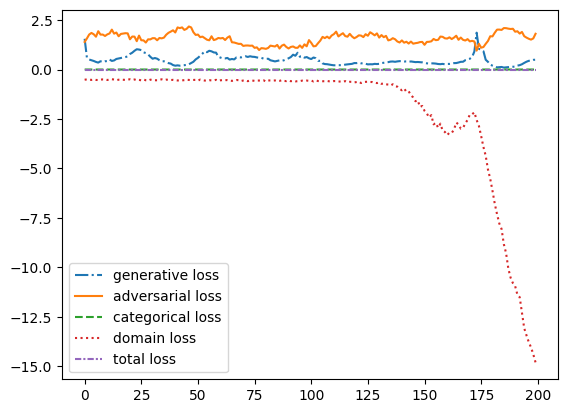

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.0


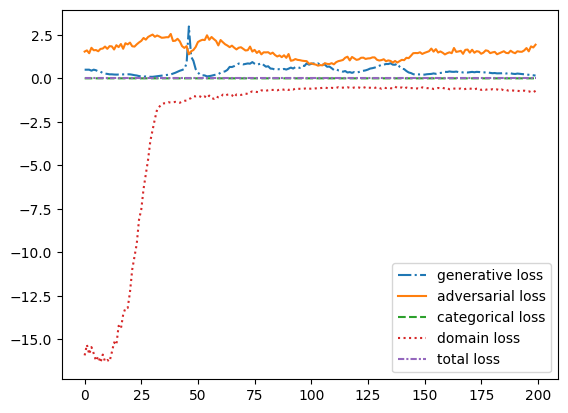

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.1


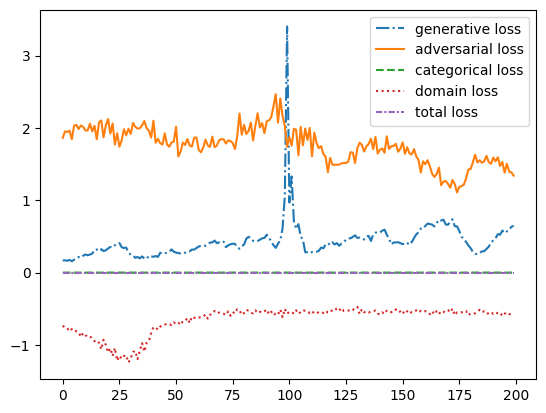

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.2


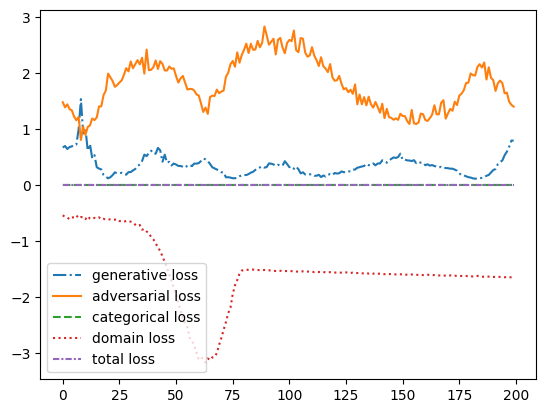

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.30000000000000004


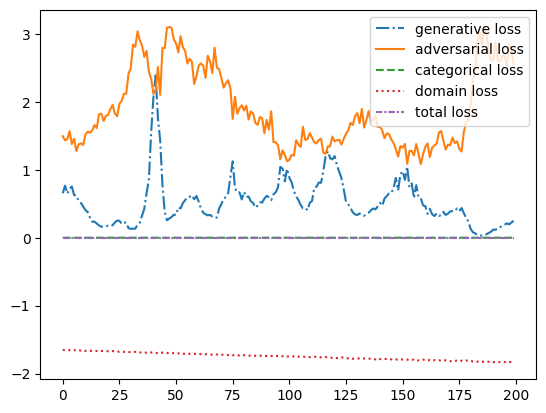

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.4


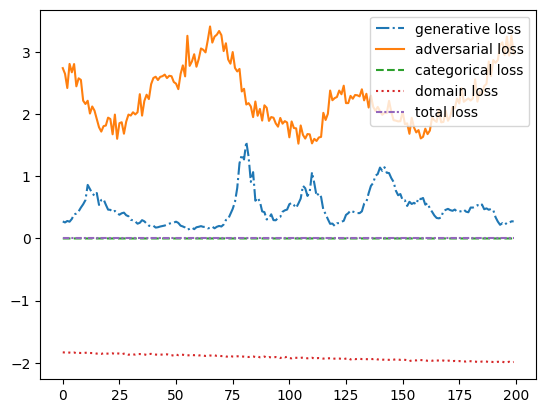

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.5


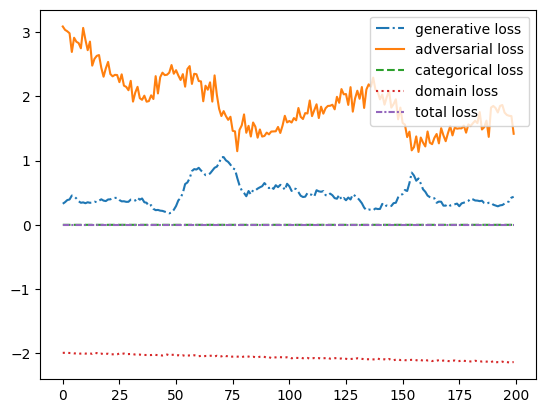

W_CATEGORICAL:  0.0
W_ADVERSARIAL:  0.2
W_DOMAIN:  0.6000000000000001


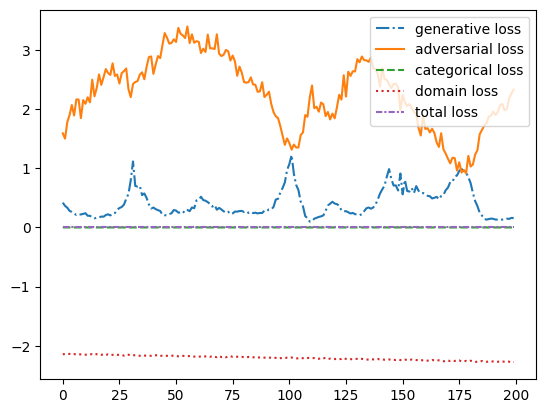

In [32]:
for i in range(27):
    print("W_CATEGORICAL: ", person['result'][i]['W_CATEGORICAL'])
    print("W_ADVERSARIAL: ", person['result'][i]['W_ADVERSARIAL'])
    print("W_DOMAIN: ", person['result'][i]['W_DOMAIN'])
    
    plot_loss_values(person['result'][i]['gl_'], person['result'][i]['al_'], person['result'][i]['cl_'], person['result'][i]['dl_'], person['result'][i]['tl_'])

In [37]:
recap_acc = person['result']

In [39]:
import pandas as pd

df = pd.DataFrame.from_records(recap_acc)
df['gl_'] = df['gl_'].map(lambda x: x[-1].numpy())
df['al_'] = df['al_'].map(lambda x: x[-1].numpy())
df['cl_'] = df['cl_'].map(lambda x: x[-1].numpy())
df['dl_'] = df['dl_'].map(lambda x: x[-1].numpy())
df['tl_'] = df['tl_'].map(lambda x: x[-1].numpy())

df['acc_source_'] = df['acc_source_'].map(lambda x: x[-1].numpy())
df['acc_target_'] = df['acc_target_'].map(lambda x: x[-1].numpy())
df['acc_source_val_'] = df['acc_source_val_'].map(lambda x: x[-1].numpy())

In [40]:
df.head()

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_,acc_source_,acc_target_,acc_source_val_
0,0.0,0.0,0.0,1.391747,0.356528,0.010229,-0.294725,0.0,0.891719,0.580938,0.686667
1,0.0,0.0,0.5,0.651652,0.781352,0.002856,-0.557517,0.0,0.945859,0.657266,0.759192
2,0.0,0.0,1.0,0.654360,0.763999,0.001678,-0.721016,0.0,0.963906,0.683229,0.787306
3,0.0,0.5,0.0,0.594636,1.222140,0.001004,-0.592932,0.0,0.972930,0.697480,0.805657
4,0.0,0.5,0.5,0.167682,3.108470,0.000569,-0.514435,0.0,0.978344,0.705578,0.817414


In [41]:
df.describe()

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_,acc_source_,acc_target_,acc_source_val_
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.000000
mean,0.500000,0.500000,0.500000,0.368779,1.805954,0.000685,-0.647376,0.0,0.984394,0.717408,0.841377
std,0.416025,0.416025,0.416025,0.264401,0.647704,0.002007,0.194428,0.0,0.021736,0.033166,0.041105
min,0.000000,0.000000,0.000000,0.084767,0.356528,0.000012,-1.154444,0.0,0.891719,0.580938,0.686667
25%,0.000000,0.000000,0.000000,0.184963,1.450891,0.000030,-0.729741,0.0,0.985498,0.714718,0.837689
50%,0.500000,0.500000,0.500000,0.339890,1.860283,0.000079,-0.592932,0.0,0.992266,0.728627,0.857576
75%,1.000000,1.000000,1.000000,0.442643,2.178017,0.000284,-0.515280,0.0,0.994715,0.735155,0.864829
max,1.000000,1.000000,1.000000,1.391747,3.108470,0.010229,-0.294725,0.0,0.995990,0.739120,0.869858


In [46]:
df[['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN','acc_source_', 'acc_target_', 'acc_source_val_']].corr().style.background_gradient(cmap ='coolwarm') 

,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,acc_source_,acc_target_,acc_source_val_
W_CATEGORICAL,1.000000,-0.000000,-0.000000,0.560168,0.623536,0.673304
W_ADVERSARIAL,-0.000000,1.000000,-0.000000,0.365325,0.364983,0.372832
W_DOMAIN,-0.000000,-0.000000,1.000000,0.190523,0.186601,0.166395
acc_source_,0.560168,0.365325,0.190523,1.000000,0.996491,0.982538
acc_target_,0.623536,0.364983,0.186601,0.996491,1.000000,0.992097
acc_source_val_,0.673304,0.372832,0.166395,0.982538,0.992097,1.000000


In [47]:
df[['W_CATEGORICAL', 'W_ADVERSARIAL', 'W_DOMAIN','gl_', 'al_', 'cl_', 'dl_', 'tl_']].corr().style.background_gradient(cmap ='coolwarm') 

/home/dcsmahasiswa1/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/dcsmahasiswa1/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,W_CATEGORICAL,W_ADVERSARIAL,W_DOMAIN,gl_,al_,cl_,dl_,tl_
W_CATEGORICAL,1.000000,-0.000000,-0.000000,-0.235193,0.082152,-0.398927,-0.249075,nan
W_ADVERSARIAL,-0.000000,1.000000,-0.000000,-0.312078,0.343402,-0.329085,-0.282602,nan
W_DOMAIN,-0.000000,-0.000000,1.000000,-0.116490,-0.039932,-0.215704,0.015430,nan
gl_,-0.235193,-0.312078,-0.116490,1.000000,-0.798076,0.843904,0.160694,nan
al_,0.082152,0.343402,-0.039932,-0.798076,1.000000,-0.556882,-0.100516,nan
cl_,-0.398927,-0.329085,-0.215704,0.843904,-0.556882,1.000000,0.382092,nan
dl_,-0.249075,-0.282602,0.015430,0.160694,-0.100516,0.382092,1.000000,nan
tl_,nan,nan,nan,nan,nan,nan,nan,nan
